## Imports and Environment Setup
Import core Python scientific libraries and the `funcs` modules. These provide GNSS data structures, time conversions, ephemeris access, and coordinate transforms used throughout the notebook.


In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from funcs.rinex import rnxdec
from funcs.gnss import Nav, epoch2time, prn2sat, uGNSS, sat2prn,\
    timeadd, ecef2pos
from funcs.ephemeris import findeph, eph2pos

## Define Initial Epoch
Create an initial epoch using `epoch2time([Y, M, D, h, m, s])` to anchor all subsequent time computations.


In [2]:
t0 = epoch2time([2021, 3, 19, 0, 0, 0]) # year, month, day, hour, minute, sec
t0.time,t0.sec

(1616112000, 0)

## Helper Imports for Visibility and Ephemeris
Bring in convenience functions for ephemeris lookup (`findeph`, `eph2pos`) and plotting utilities (`skyplot`, `plot_elv`). These help inspect and visualize satellite geometry before PPP.


In [8]:
import numpy as np
from funcs.gnss import Nav, ecef2pos, geodist, satazel, timediff, uGNSS, rSigRnx, sat2prn
from funcs.ephemeris import findeph, eph2pos
from funcs.plot import skyplot, plot_elv
from funcs.rinex import rnxdec

## RINEX Files and Signal Selection
Set RINEX navigation/observation file paths, initialize the decoder, load navigation data, and specify the signals to be processed (e.g., GPS L1 C/A, L2.)


In [43]:
navfile = 'data/SEPT1890.23P'
obsfile = 'data/SEPT1890.23O'

dec = rnxdec()
nav = dec.decode_nav(navfile,Nav())

sigs = [rSigRnx("GC1C"), rSigRnx("GC2W")]
dec.setSignals(sigs)

### Build Visibility Matrices (Azimuth/Elevation)
Parse observations and compute azimuth/elevation per satellite and epoch. These matrices are later used for skyplot and elevation-angle visualizations.


In [44]:
nep = 15*60  # 15 minutes
elv = np.ones((nep, uGNSS.MAXSAT))*np.nan
azm = np.ones((nep, uGNSS.MAXSAT))*np.nan
t = np.zeros(nep)*np.nan

if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    pos = ecef2pos(rr)
    for ne in range(nep):
        print('\repoch=%d/%d' % (ne, nep), end='')
        obs = dec.decode_obs()
        if ne == 0:
            t0 = obs.t
        t[ne] = timediff(obs.t, t0)
        for k, sat in enumerate(obs.sat):
            eph = findeph(nav.eph, obs.t, sat)
            if eph is None:
                continue
            rs, dts = eph2pos(obs.t, eph)
            r, e = geodist(rs, rr)
            azm[ne, sat-1], elv[ne, sat-1] = satazel(pos, e)
    dec.fobs.close()

epoch=899/900

## Skyplot and GPS Ground Tracks
Visualize satellite geometry with a skyplot and approximate ground tracks for GPS satellites over a 24-hour span at 5-minute intervals. This helps assess geometry and coverage qualitatively.


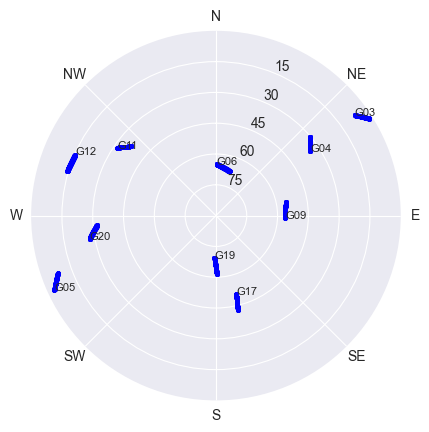

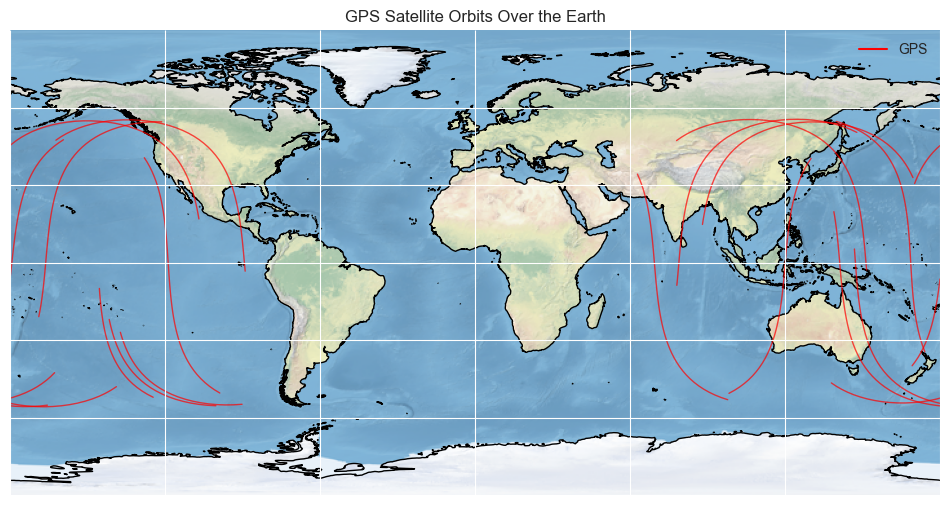

In [45]:
nsat = skyplot(azm, elv, elmask=0)

# Visualize GPS satellite orbits over the Earth
import cartopy.crs as ccrs
from funcs.gnss import timeadd

lon0 = 135
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()

n = 24*3600//300  # 24 hours with 5-minute intervals
pos = np.zeros((n, 3))
r2d = 180/np.pi

# Color definition for GPS satellites
gps_color = 'red'

# Process only GPS satellites
for k in range(uGNSS.MAXSAT):
    sat = k+1
    sys, prn = sat2prn(sat)
    
    # Include only GPS satellites
    if sys != uGNSS.GPS:
        continue
    
    # Calculate orbit for each GPS satellite
    valid_positions = []
    for i in range(n):
        t = timeadd(t0, i*300)
        eph = findeph(nav.eph, t, sat)
        if eph is None:
            continue
        rs, dts = eph2pos(t, eph)
        pos_temp = ecef2pos(rs)
        valid_positions.append([pos_temp[1]*r2d, pos_temp[0]*r2d])
    
    # Plot if valid positions exist
    if valid_positions:
        valid_positions = np.array(valid_positions)
        plt.plot(valid_positions[:, 0], valid_positions[:, 1], 
                color=gps_color, linewidth=1, 
                transform=ccrs.Geodetic(), alpha=0.7)

# Add legend
legend_elements = [plt.Line2D([0], [0], color=gps_color, label='GPS')]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('GPS Satellite Orbits Over the Earth')
plt.show()

## PPP Modules and Session Setup

The following cells import the required PPP components and set up the session:
- import core GNSS utilities and the PPP engine
- define the initial epoch and session parameters
- specify RINEX NAV/OBS file paths
- load IGS precise products (SP3 orbits, CLK clocks, OSB biases, ANTEX PCV)
- set the reference station position (ECEF)
- choose the GPS-only signal set to be processed


In [20]:
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from sys import stdout

import funcs.gnss as gn
from funcs.gnss import ecef2pos, Nav
from funcs.gnss import time2doy, time2str, timediff, epoch2time
from funcs.gnss import rSigRnx
from funcs.gnss import sys2str
from funcs.peph import atxdec, searchpcv
from funcs.peph import peph, biasdec
from funcs.pppmod import pppos
from funcs.rinex import rnxdec

In [27]:
# Initial time
ep = [2023, 6, 29, 0, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

# RINEX files (using forward slash)
navfile = r'C:\Users\Root\Desktop\tiger\data\BRDC00IGS_R_20231890000_01D_MN.rnx'
obsfile = r'C:\Users\Root\Desktop\tiger\data\SEPT1890.23O'

# IGS PPP correction files
orbfile = r'C:\Users\Root\Desktop\tiger\data\COD0MGXFIN_20231890000_01D_05M_ORB.SP3'
clkfile = r'C:\Users\Root\Desktop\tiger\data\COD0MGXFIN_20231890000_01D_30S_CLK.CLK'
bsxfile = r'C:\Users\Root\Desktop\tiger\data\COD0MGXFIN_20231890000_01D_01D_OSB.BIA'
atxfile = r'C:\Users\Root\Desktop\tiger\data\I20.ATX'

# Reference position
xyz_ref = [-3962108.6829,  3381309.5384,  3668678.6617]
pos_ref = ecef2pos(xyz_ref)

# GPS SIGNALS ONLY
# G: GPS, S: SBAS (GPS auxiliary system)
sigs = [
    rSigRnx("GC1C"), rSigRnx("GC2W"),  # GPS L1 C/A and L2 P(Y)
    rSigRnx("GL1C"), rSigRnx("GL2W"),  # GPS L1/L2 carrier phase
    rSigRnx("GS1C"), rSigRnx("GS2W"),  # GPS L1/L2 signal strength
]

In [28]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0  # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load precise orbit and clock corrections
nav = orb.parse_sp3(orbfile, nav)
nav = rnx.decode_clk(clkfile, nav)

# Load code and phase biases
bsx = biasdec()
bsx.parse(bsxfile)

# Load ANTEX data
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Log level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:
    # Auto substitute signals
    rnx.autoSubstituteSignals()

    # Initialize PPP
    ppp = pppos(nav, rnx.pos, 'gps_only_ppp.log', iono_opt=1, )
    nav.ephopt = 4  # Use IGS products
    nav.armode = 1  # Ambiguity resolution mode 

    # Modify default settings
    nav.elmin = np.deg2rad(5.0)  # Min. satellite elevation angle
    nav.thresar = 2.0            # Ambiguity resolution threshold

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant, rnx.ts)

    print("PPP initialized - GPS only will be used")

PPP initialized - GPS only will be used


In [29]:
print("=" * 50)
print("AVAILABLE SIGNALS:")
print("=" * 50)
for sys, sigs in rnx.sig_map.items():
    if sys == gn.uGNSS.GPS:
        txt = "{:7s} {}".format(sys2str(sys),
              ' '.join([sig.str() for sig in sigs.values()]))
        print(txt)

print("\n" + "=" * 50)
print("SELECTED SIGNALS (GPS ONLY):")
print("=" * 50)
for sys, tmp in rnx.sig_tab.items():
    if sys == gn.uGNSS.GPS:  # Show GPS only
        txt = "{:7s} ".format(sys2str(sys))
        for _, sigs in tmp.items():
            txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
        print(txt)

AVAILABLE SIGNALS:
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q

SELECTED SIGNALS (GPS ONLY):
GPS     C1C C2W L1C L2W S1C S2W 


## PPP Processing Loop

Run the PPP engine epoch-by-epoch. For each observation epoch, process with precise products, save ENU errors and solution mode, and report progress. Stop when the observation file reaches the end.

In [30]:
# Processing time (minutes)
nep = 30 * 60  # 15 minutes

# Initialize result data structures
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)
nsat_gps = np.zeros(nep, dtype=int)  # GPS satellite count

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

print("PPP processing continues until last observation...")
print("=" * 70)

# Loop for each epoch
for ne in range(nep):
    # Set start time at first epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)

    # Count GPS satellites
    gps_sats = [sat for sat in obs.sat if gn.sat2prn(sat)[0] == gn.uGNSS.GPS]
    nsat_gps[ne] = len(gps_sats)
    
    # Call PPP module with IGS products
    ppp.process(obs, orb=orb, bsx=bsx)

    # Save results
    t[ne] = timediff(nav.t, t0) / 60.0  # in minutes
    
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Show progress
    stdout.write('\r{} | GPS Sat: {:2d} | ENU: {:7.3f} {:7.3f} {:7.3f} m | '
                 '2D Error: {:6.3f} m | Mode: {:1d}'
                 .format(time2str(obs.t), nsat_gps[ne],
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()
print("\n" + "=" * 70)
print("PPP processing completed!")

PPP processing continues until last observation...
2023-07-08 04:30:00 | GPS Sat: 10 | ENU:   0.304   0.271  -0.635 m | 2D Error:  0.408 m | Mode: 5
PPP processing completed!


## Time Data Summary

Basic sanity checks for the time vector: number of epochs, span, average epoch interval, and a heuristic check of session length based on expected sampling intervals.

In [31]:
# Time data analysis
print("="*50)
print("TIME DATA ANALYSIS")
print("="*50)
print(f"Total number of epochs: {len(t)}")
print(f"First epoch time: {t[0]:.2f} minutes")
print(f"Last epoch time: {t[-1]:.2f} minutes")
print(f"Total duration: {t[-1] - t[0]:.2f} minutes ({(t[-1] - t[0])/60:.2f} hours)")
print(f"Average epoch interval: {np.mean(np.diff(t)):.2f} minutes")
print(f"Epoch interval (seconds): {np.mean(np.diff(t))*60:.1f} seconds")

# Data rate control
expected_1hour_30s = 120  # 1 hour, 30 second interval = 120 epochs
expected_1hour_15s = 240  # 1 hour, 15 second interval = 240 epochs
expected_1hour_5s = 720   # 1 hour, 5 second interval = 720 epochs

print(f"\nExpected epoch counts (for 1 hour):")
print(f"30 second interval: {expected_1hour_30s}")
print(f"15 second interval: {expected_1hour_15s}")
print(f"5 second interval: {expected_1hour_5s}")

# Data source check
print(f"\nCurrent epoch count: {len(t)}")
if len(t) < 60:
    print("This data is not 1 hour long, it covers a shorter duration")
elif len(t) < 120:
    print("This data appears to be approximately 30 minutes long")
else:
    print("This data might be 1 hour long")

print("="*50)

TIME DATA ANALYSIS
Total number of epochs: 1800
First epoch time: 0.00 minutes
Last epoch time: 29.98 minutes
Total duration: 29.98 minutes (0.50 hours)
Average epoch interval: 0.02 minutes
Epoch interval (seconds): 1.0 seconds

Expected epoch counts (for 1 hour):
30 second interval: 120
15 second interval: 240
5 second interval: 720

Current epoch count: 1800
This data might be 1 hour long


## Positioning Errors and Satellite Count Over Time

Plot East, North, and Up errors along with the number of visible GPS satellites per epoch. Dynamic y-axis limits are used to maintain readability across different scales.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


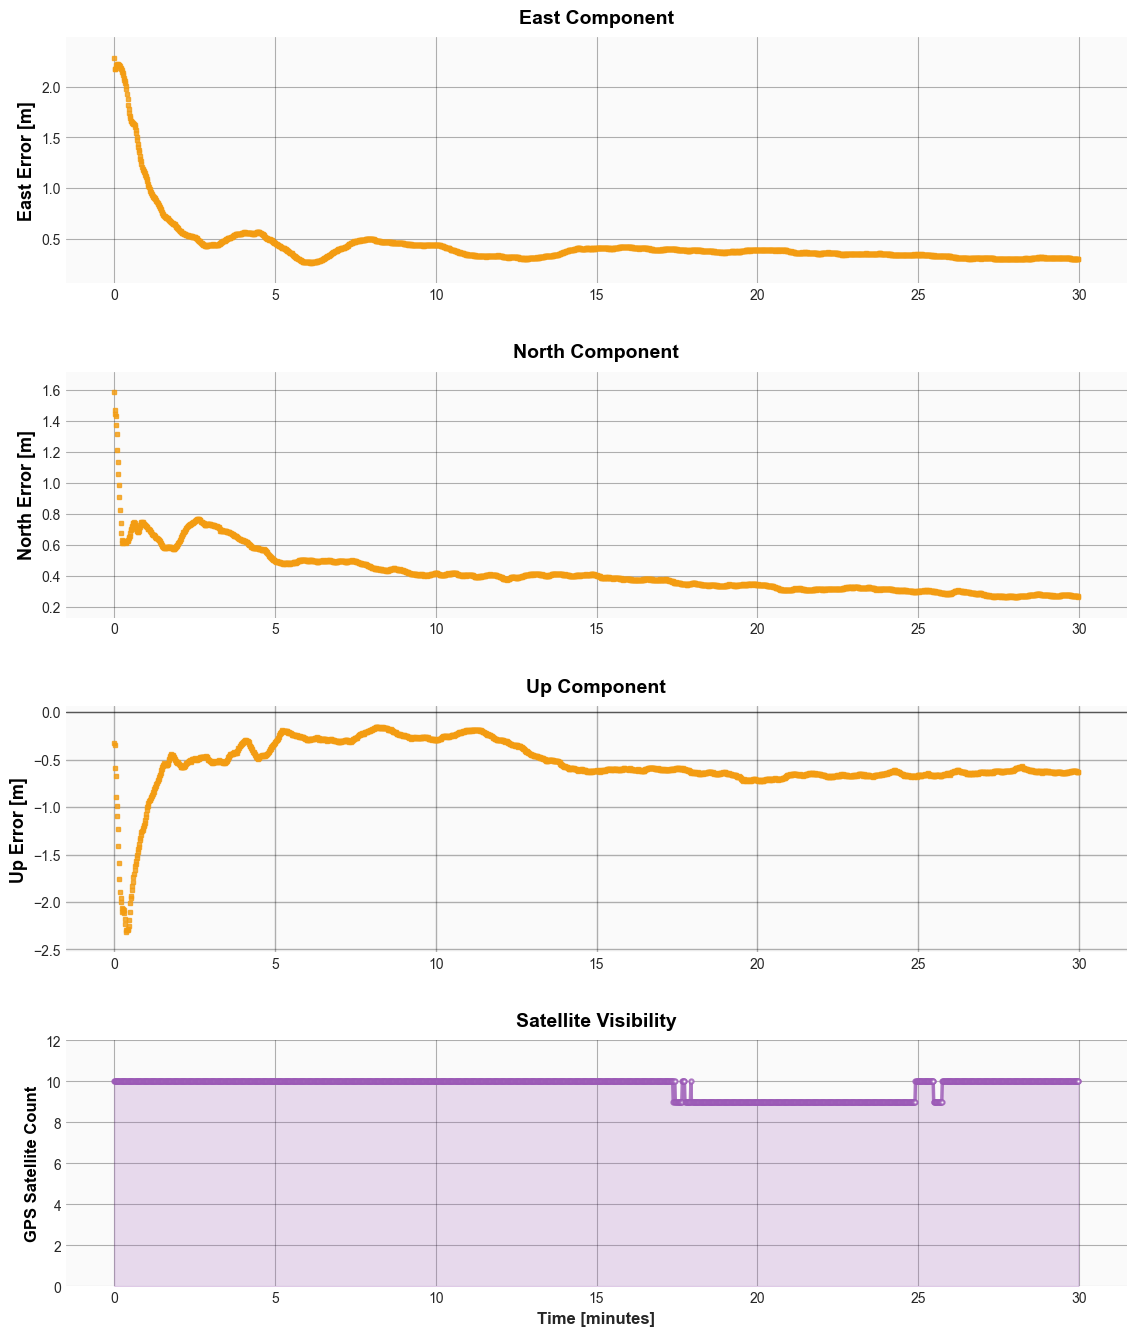


DYNAMIC Y-AXIS RANGES
East Error Range: 0.066 to 2.485 m
North Error Range: 0.133 to 1.720 m
Up Error Range: -2.529 to 0.065 m

GPS-ONLY PPP PERFORMANCE SUMMARY
Total Epochs: 1800
Fixed Solutions: 0 (0.0%)
Float Solutions: 1800 (100.0%)
No Solutions: 0 (0.0%)


In [32]:
# Separate solution modes
idx4 = np.where(smode == 4)[0]  # Fixed solution
idx5 = np.where(smode == 5)[0]  # Float solution  
idx0 = np.where(smode == 0)[0]  # No solution

# Modern color palette with requested colors
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'no_solution': '#95A5A6',    # Light gray for no solution
    'float': '#F39C12',          # Orange for float
    'fixed_east': '#000000',     # Blue for East
    'fixed_north': '#000000',    # Green for North
    'fixed_up': '#000000',       # Red for Up
    'satellite': '#9B59B6',      # Purple for satellites
    'grid': '#000000'            # Black
}

# Calculate dynamic Y-axis limits with some padding
def get_ylim_with_padding(data, padding_factor=0.1):
    """Calculate Y-axis limits with padding"""
    if len(data) == 0:
        return [-0.1, 0.1]
    data_min = np.min(data)
    data_max = np.max(data)
    data_range = data_max - data_min
    padding = data_range * padding_factor if data_range > 0 else 0.1
    return [data_min - padding, data_max + padding]

# Get Y-limits for each component
ylim_east = get_ylim_with_padding(enu[:, 0])
ylim_north = get_ylim_with_padding(enu[:, 1]) 
ylim_up = get_ylim_with_padding(enu[:, 2])

fig = plt.figure(figsize=[12, 14])
fig.patch.set_facecolor('white')

# East error - BLUE
plt.subplot(4, 1, 1)
plt.plot(t[idx0], enu[idx0, 0], 'o', color=colors['no_solution'], 
         markersize=4, alpha=0.7, label='No Solution')
plt.plot(t[idx5], enu[idx5, 0], 's', color=colors['float'], 
         markersize=3, alpha=0.8, label='Float Solution')
plt.plot(t[idx4], enu[idx4, 0], '^', color=colors['fixed_east'], 
         markersize=4, alpha=0.9, label='Fixed Solution')
plt.ylabel('East Error [m]', fontsize=13, fontweight='bold', color=colors['fixed_east'])
plt.grid(True, alpha=0.3, color=colors['grid'])
plt.ylim(ylim_east)  # Dynamic limits
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.title('East Component', fontsize=14,fontweight='bold', pad=10, color=colors['fixed_east'])

# North error - GREEN
plt.subplot(4, 1, 2)
plt.plot(t[idx0], enu[idx0, 1], 'o', color=colors['no_solution'], 
         markersize=4, alpha=0.7)
plt.plot(t[idx5], enu[idx5, 1], 's', color=colors['float'], 
         markersize=3, alpha=0.8)
plt.plot(t[idx4], enu[idx4, 1], '^', color=colors['fixed_north'], 
         markersize=4, alpha=0.9)
plt.ylabel('North Error [m]', fontsize=13, fontweight='bold', color=colors['fixed_north'])
plt.grid(True, alpha=0.3, color=colors['grid'])
plt.ylim(ylim_north)  # Dynamic limits
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.title('North Component', fontsize=14,fontweight='bold', pad=10, color=colors['fixed_north'])

# Up error - RED
plt.subplot(4, 1, 3)
plt.plot(t[idx0], enu[idx0, 2], 'o', color=colors['no_solution'], 
         markersize=4, alpha=0.7)
plt.plot(t[idx5], enu[idx5, 2], 's', color=colors['float'], 
         markersize=3, alpha=0.8)
plt.plot(t[idx4], enu[idx4, 2], '^', color=colors['fixed_up'], 
         markersize=4, alpha=0.9)
plt.ylabel('Up Error [m]', fontsize=13, fontweight='bold', color=colors['fixed_up'])
plt.grid(True, alpha=0.3, linewidth=1, color=colors['grid'])
plt.ylim(ylim_up)  # Dynamic limits
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.title('Up Component', fontsize=14,fontweight='bold', pad=10, color=colors['fixed_up'])

# Legend with custom styling
legend = plt.legend(loc='upper right', fontsize=11, framealpha=0.9, 
                   fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(colors['grid'])

# GPS satellite count - PURPLE
plt.subplot(4, 1, 4)
plt.plot(t, nsat_gps, color=colors['satellite'], linewidth=2.5, 
         marker='o', markersize=3, alpha=0.8, markerfacecolor='white', 
         markeredgecolor=colors['satellite'], markeredgewidth=1.5)
plt.fill_between(t, nsat_gps, alpha=0.2, color=colors['satellite'])
plt.ylabel('GPS Satellite Count', fontsize=12, fontweight='bold', color=colors['grid'])
plt.xlabel('Time [minutes]', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, color=colors['grid'])
plt.ylim([0, max(nsat_gps)+2])
plt.title('Satellite Visibility', fontsize=14,fontweight='bold', pad=10, color=colors['grid'])

# Add subtle background color to subplots
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plt.gca().set_facecolor('#FAFAFA')

plt.tight_layout(pad=3.0)
plt.show()

# Print Y-axis ranges for reference
print("\n" + "="*60)
print("DYNAMIC Y-AXIS RANGES")
print("="*60)
print(f"East Error Range: {ylim_east[0]:.3f} to {ylim_east[1]:.3f} m")
print(f"North Error Range: {ylim_north[0]:.3f} to {ylim_north[1]:.3f} m")
print(f"Up Error Range: {ylim_up[0]:.3f} to {ylim_up[1]:.3f} m")

# Print summary statistics
print("\n" + "="*60)
print("GPS-ONLY PPP PERFORMANCE SUMMARY")
print("="*60)
print(f"Total Epochs: {len(t)}")
print(f"Fixed Solutions: {len(idx4)} ({len(idx4)/len(t)*100:.1f}%)")
print(f"Float Solutions: {len(idx5)} ({len(idx5)/len(t)*100:.1f}%)")
print(f"No Solutions: {len(idx0)} ({len(idx0)/len(t)*100:.1f}%)")

if len(idx4) > 0:
    print(f"\nFixed Solution Statistics:")
    print(f"East RMS: {np.sqrt(np.mean(enu[idx4, 0]**2)):.3f} m")
    print(f"North RMS: {np.sqrt(np.mean(enu[idx4, 1]**2)):.3f} m") 
    print(f"Up RMS: {np.sqrt(np.mean(enu[idx4, 2]**2)):.3f} m")
    print(f"2D RMS: {np.sqrt(np.mean(enu[idx4, 0]**2 + enu[idx4, 1]**2)):.3f} m")
    print(f"3D RMS: {np.sqrt(np.mean(enu[idx4, 0]**2 + enu[idx4, 1]**2 + enu[idx4, 2]**2)):.3f} m")
print("="*60)

## Horizontal Error Scatter (East vs. North)

Plot horizontal errors centered at the origin with concentric reference circles (0.5–2.0 m). This helps visualize planar spread and bias in the solution.


Data range - East: 0.267 to 2.283 m
Data range - North: 0.265 to 1.587 m
Plot limits: ±2.7m from origin


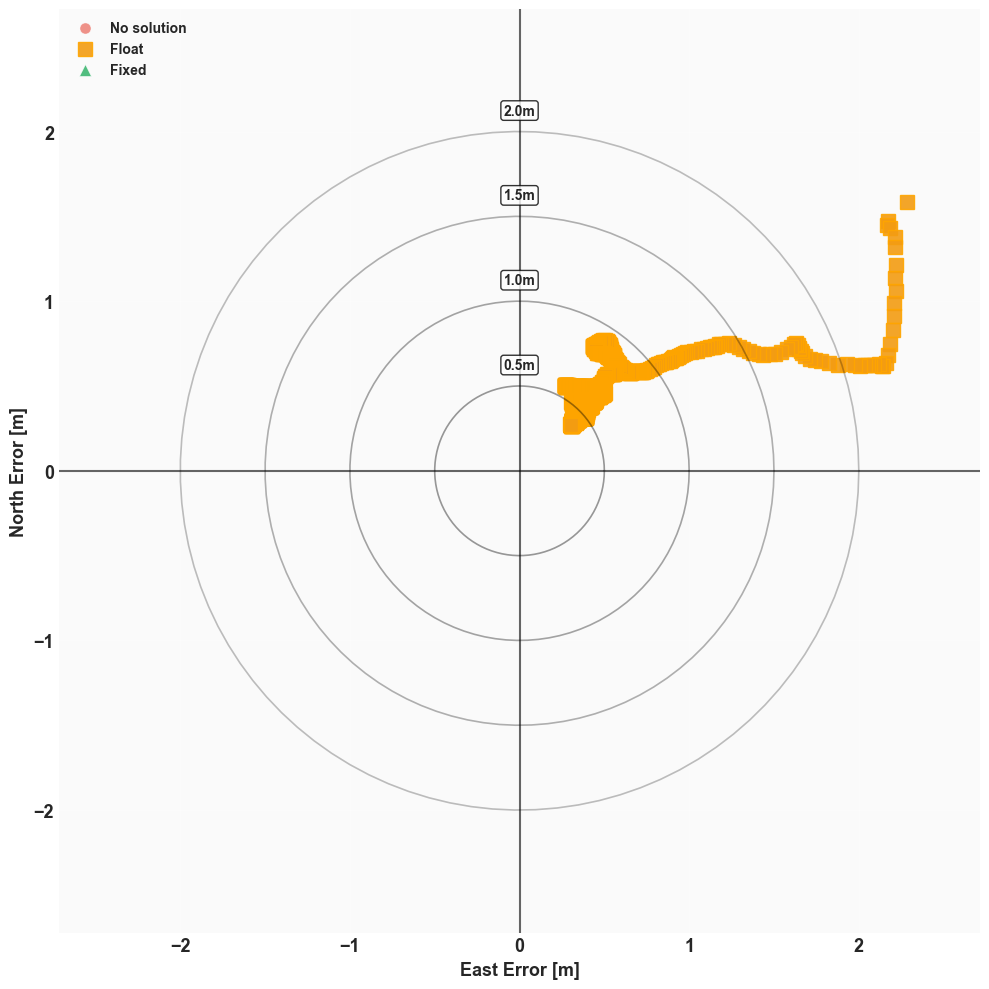


CENTERED PLOT STATISTICS
Plot range: ±2.7m from origin
Reference circles: 0.5m, 1.0m, 1.5m, 2.0m
Data coverage: 83.3% of plot area


In [33]:
# Plot horizontal error scatter with dynamic scaling and centered origin
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')

# Calculate dynamic plot limits based on actual data
all_east = enu[:, 0]
all_north = enu[:, 1]

# Find data range for dynamic scaling
east_range = [np.min(all_east), np.max(all_east)]
north_range = [np.min(all_north), np.max(all_north)]

# Calculate maximum extent from origin (0,0) for centering
max_extent = max(abs(east_range[0]), abs(east_range[1]),
                 abs(north_range[0]), abs(north_range[1]))

# Dynamic plot limits centered on origin (0,0)
plot_limit = max(2.2, max_extent * 1.2)  # At least 2.2m to show 2.0m circle, or 20% padding

print(f"Data range - East: {east_range[0]:.3f} to {east_range[1]:.3f} m")
print(f"Data range - North: {north_range[0]:.3f} to {north_range[1]:.3f} m")
print(f"Plot limits: ±{plot_limit:.1f}m from origin")

# Enhanced styling - keep original structure but improve colors and visibility
plt.plot(enu[idx0, 0], enu[idx0, 1], 'o', color='#E74C3C', markersize=8, 
         label='No solution', alpha=0.6, markeredgewidth=0.5, markeredgecolor='white')
plt.plot(enu[idx5, 0], enu[idx5, 1], 's', color='#F39C12', markersize=10, 
         label='Float', alpha=0.9, markeredgewidth=1, markeredgecolor='orange')
plt.plot(enu[idx4, 0], enu[idx4, 1], '^', color='#27AE60', markersize=8, 
         label='Fixed', alpha=0.8, markeredgewidth=0.5, markeredgecolor='white')

# Fixed reference circles: 0.5, 1.0, 1.5, 2.0 meters
circles = [0.5, 1.0, 1.5, 2.0]
theta = np.linspace(0, 2*np.pi, 100)

for i, r in enumerate(circles):
    # Center circles on origin (0,0)
    circle_x = r*np.cos(theta)
    circle_y = r*np.sin(theta)
    alpha_val = 0.4 - i*0.05  # Decreasing alpha for outer circles
    plt.plot(circle_x, circle_y, 'k-', alpha=max(0.15, alpha_val), linewidth=1.2)
    
    # Position text at the top of each circle
    text_x = 0
    text_y = r + plot_limit*0.03
    plt.text(text_x, text_y, f'{r:.1f}m', ha='center', va='bottom', 
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Enhanced labels with better styling
plt.xlabel('East Error [m]', fontsize=13, fontweight='bold')
plt.ylabel('North Error [m]', fontsize=13, fontweight='bold')

# Keep original axis equal and grid
plt.axis('equal')
plt.grid(True, alpha=0.3, linewidth=0.8)

# Apply dynamic limits centered on origin
plt.xlim([-plot_limit, plot_limit])
plt.ylim([-plot_limit, plot_limit])

# Enhanced center lines at origin (0,0)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.6, linewidth=1.5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.6, linewidth=1.5)

# Enhanced legend with bold text
plt.legend(fontsize=30, framealpha=0.95, fancybox=True, shadow=True, loc='upper left', 
          prop={'weight': 'bold'})

# Set bold tick labels
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')

# Subtle background
plt.gca().set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()

# Print summary with dynamic ranges
print("\n" + "="*50)
print("CENTERED PLOT STATISTICS")
print("="*50)
print(f"Plot range: ±{plot_limit:.1f}m from origin")
print(f"Reference circles: {', '.join([f'{r:.1f}m' for r in circles])}")
print(f"Data coverage: {max_extent/plot_limit*100:.1f}% of plot area")
print("="*50)

## GPS-Only PPP Statistics

Summarize overall PPP performance: total epochs, solution mode breakdown (float/fix), and RMS metrics (East, North, Up, 2D, 3D). Percentiles are also reported for quick quality assessment.


In [34]:
# Calculate and display statistics
print("=" * 60)
print("GPS-ONLY PPP STATISTICS")
print("=" * 60)
print(f"Total epochs processed: {len(t)}")
print(f"Time span: {t[-1]:.1f} minutes")
print(f"Average GPS satellite count: {np.mean(nsat_gps):.1f}")
print(f"GPS satellite range: {int(np.min(nsat_gps))} - {int(np.max(nsat_gps))}")

# Float solution statistics
if len(idx5) > 0:
    print(f"\nFloat Solution Statistics ({len(idx5)} epochs, {len(idx5)/len(t)*100:.1f}%):")
    print(f"  East RMS:   {np.std(enu[idx5, 0]):.3f} m")
    print(f"  North RMS:  {np.std(enu[idx5, 1]):.3f} m")
    print(f"  Up RMS:     {np.std(enu[idx5, 2]):.3f} m")
    print(f"  2D RMS:     {np.std(np.sqrt(enu[idx5, 0]**2 + enu[idx5, 1]**2)):.3f} m")
    print(f"  3D RMS:     {np.std(np.sqrt(enu[idx5, 0]**2 + enu[idx5, 1]**2 + enu[idx5, 2]**2)):.3f} m")
    
    # 95th percentile errors
    print(f"\n  95th Percentile Errors:")
    print(f"    Horizontal: {np.percentile(np.sqrt(enu[idx5, 0]**2 + enu[idx5, 1]**2), 95):.3f} m")
    print(f"    Vertical:   {np.percentile(np.abs(enu[idx5, 2]), 95):.3f} m")

# Fixed solution statistics (if any)
if len(idx4) > 0:
    print(f"\nFixed Solution Statistics ({len(idx4)} epochs, {len(idx4)/len(t)*100:.1f}%):")
    print(f"  East RMS:   {np.std(enu[idx4, 0]):.3f} m")
    print(f"  North RMS:  {np.std(enu[idx4, 1]):.3f} m")
    print(f"  Up RMS:     {np.std(enu[idx4, 2]):.3f} m")
    print(f"  2D RMS:     {np.std(np.sqrt(enu[idx4, 0]**2 + enu[idx4, 1]**2)):.3f} m")
    print(f"  3D RMS:     {np.std(np.sqrt(enu[idx4, 0]**2 + enu[idx4, 1]**2 + enu[idx4, 2]**2)):.3f} m")
else:
    print("\nNo fixed solutions achieved (typical for GPS-only PPP without long convergence)")

print("=" * 60)

GPS-ONLY PPP STATISTICS
Total epochs processed: 1800
Time span: 30.0 minutes
Average GPS satellite count: 9.7
GPS satellite range: 9 - 10

Float Solution Statistics (1800 epochs, 100.0%):
  East RMS:   0.272 m
  North RMS:  0.144 m
  Up RMS:     0.278 m
  2D RMS:     0.293 m
  3D RMS:     0.354 m

  95th Percentile Errors:
    Horizontal: 0.962 m
    Vertical:   0.719 m

No fixed solutions achieved (typical for GPS-only PPP without long convergence)


## PPP Convergence Analysis

Compute instantaneous error series and 1-minute running RMS for horizontal and vertical components. Visualize the convergence behavior and extract indicative thresholds.

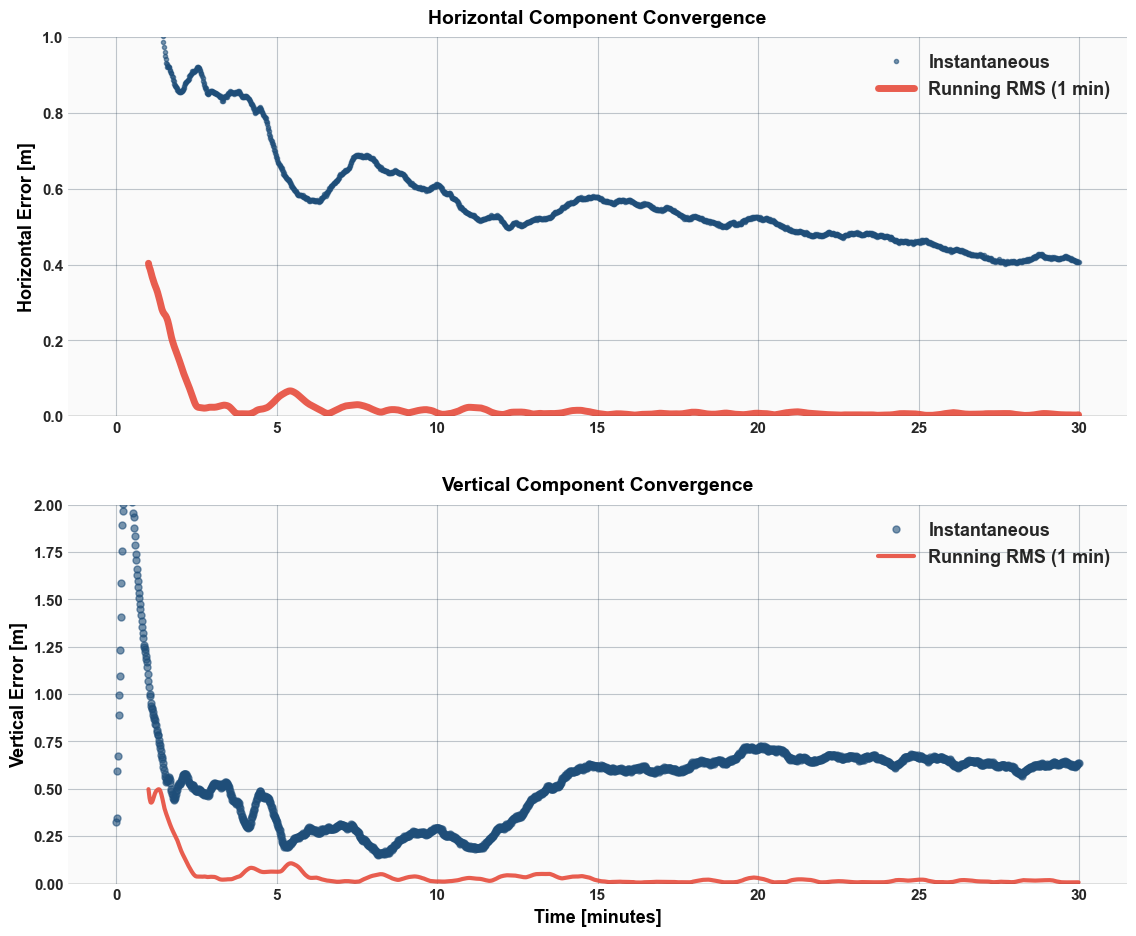


PPP CONVERGENCE STATISTICS
Horizontal Convergence:
  10cm accuracy: 2.2 minutes
  20cm accuracy: 1.8 minutes

Vertical Convergence:
  20cm accuracy: 2.0 minutes
  50cm accuracy: 1.0 minutes

Final Performance:
  Final Horizontal RMS: 0.004 m
  Final Vertical RMS: 0.007 m


In [35]:
# Analyze convergence behavior
horizontal_error = np.sqrt(enu[:, 0]**2 + enu[:, 1]**2)
vertical_error = np.abs(enu[:, 2])

# Calculate running RMS
window_size = 60  # 1 minute window
running_h_rms = []
running_v_rms = []
time_windows = []

for i in range(window_size, len(horizontal_error)):
    if smode[i] > 0:  # Only consider epochs with solutions
        h_window = horizontal_error[i-window_size:i]
        v_window = vertical_error[i-window_size:i]
        valid_idx = smode[i-window_size:i] > 0
        
        if np.sum(valid_idx) > 10:  # Need at least 10 valid epochs
            running_h_rms.append(np.std(h_window[valid_idx]))
            running_v_rms.append(np.std(v_window[valid_idx]))
            time_windows.append(t[i])

# Apply consistent styling
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'data': '#1f4e79',           # Dark blue for data points
    'running_rms': '#E74C3C',    # Red for running RMS
    'grid': '#34495E'            # Dark gray for grid
}

# Plot convergence with enhanced styling
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[12, 10])
fig.patch.set_facecolor('white')

# Horizontal convergence
ax1.plot(t, horizontal_error, 'o', color=colors['data'], alpha=0.6, 
         markersize=3, label='Instantaneous', markeredgewidth=1, markeredgecolor=colors['data'])
if len(running_h_rms) > 0:
    ax1.plot(time_windows, running_h_rms, '-', color=colors['running_rms'], 
             linewidth=5, label='Running RMS (1 min)', alpha=0.9)
ax1.set_ylabel('Horizontal Error [m]', fontsize=13, fontweight='bold', color='black')
ax1.set_ylim([0, 1.0])
ax1.grid(True, alpha=0.3, color=colors['grid'], linewidth=0.8)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax1.set_title('Horizontal Component Convergence', fontsize=14, fontweight='bold', 
              pad=10, color='black')
ax1.set_facecolor('#FAFAFA')

# Enhanced legend for horizontal with bold text
legend1 = ax1.legend(fontsize=13, framealpha=0.95, fancybox=True, shadow=True, loc='upper right')
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_edgecolor(colors['grid'])
# Make legend text bold
for text in legend1.get_texts():
    text.set_fontweight('bold')

# Vertical convergence
ax2.plot(t, vertical_error, 'o', color=colors['data'], alpha=0.6, 
         markersize=5, label='Instantaneous', markeredgewidth=1, markeredgecolor=colors['data'])
if len(running_v_rms) > 0:
    ax2.plot(time_windows, running_v_rms, '-', color=colors['running_rms'], 
             linewidth=3, label='Running RMS (1 min)', alpha=0.9)
ax2.set_ylabel('Vertical Error [m]', fontsize=13, fontweight='bold', color='black')
ax2.set_xlabel('Time [minutes]', fontsize=13, fontweight='bold', color='black')
ax2.set_ylim([0, 2.0])
ax2.grid(True, alpha=0.3, color=colors['grid'], linewidth=0.8)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax2.set_title('Vertical Component Convergence', fontsize=14, fontweight='bold', 
              pad=10, color='black')
ax2.set_facecolor('#FAFAFA')

# Enhanced legend for vertical with bold text
legend2 = ax2.legend(fontsize=13, framealpha=0.95, fancybox=True, shadow=True, loc='upper right')
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_edgecolor(colors['grid'])
# Make legend text bold
for text in legend2.get_texts():
    text.set_fontweight('bold')



# Make all tick labels bold
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=11)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

plt.tight_layout(pad=3.0)
plt.show()

# Print convergence statistics with bold formatting
print("\n" + "="*60)
print("PPP CONVERGENCE STATISTICS")
print("="*60)

if len(running_h_rms) > 0 and len(running_v_rms) > 0:
    # Find convergence times (when RMS drops below thresholds)
    h_conv_10cm = next((i for i, rms in enumerate(running_h_rms) if rms < 0.1), None)
    h_conv_20cm = next((i for i, rms in enumerate(running_h_rms) if rms < 0.2), None)
    v_conv_20cm = next((i for i, rms in enumerate(running_v_rms) if rms < 0.2), None)
    v_conv_50cm = next((i for i, rms in enumerate(running_v_rms) if rms < 0.5), None)
    
    print(f"Horizontal Convergence:")
    if h_conv_10cm is not None:
        print(f"  10cm accuracy: {time_windows[h_conv_10cm]:.1f} minutes")
    if h_conv_20cm is not None:
        print(f"  20cm accuracy: {time_windows[h_conv_20cm]:.1f} minutes")
    
    print(f"\nVertical Convergence:")
    if v_conv_20cm is not None:
        print(f"  20cm accuracy: {time_windows[v_conv_20cm]:.1f} minutes")
    if v_conv_50cm is not None:
        print(f"  50cm accuracy: {time_windows[v_conv_50cm]:.1f} minutes")
    
    print(f"\nFinal Performance:")
    print(f"  Final Horizontal RMS: {running_h_rms[-1]:.3f} m")
    print(f"  Final Vertical RMS: {running_v_rms[-1]:.3f} m")

print("="*60)

## Export Results to RTKLib Format

The function below converts ENU solutions to ECEF and writes an RTKLib-compatible `.pos` file. This enables external visualization (e.g., RTKPlot) and interoperability with other GNSS toolchains.


In [36]:
# ... existing code ...

# Print results in RTKLib format
def save_rtklib_pos_results(output_file, epoch_times, enu_pos, solution_modes, nsat_gps, 
                           std_errors, ref_pos=None):
    """
    Print results in RTKLib .pos format
    Converts ENU coordinates to ECEF
    """
    import numpy as np
    from datetime import datetime, timedelta
    
    # Reference position (ECEF) - for SEPT station
    # Update these values with actual station coordinates
    if ref_pos is None:
        # Example ECEF coordinates (meters)
        ref_ecef = np.array([-3962108.0, 3381308.0, 3668679.0])
    else:
        ref_ecef = np.array(ref_pos)
    
    # ENU to ECEF conversion, calculate lat/lon of reference position
    def ecef_to_lla(ecef):
        """ECEF to Lat/Lon/Alt conversion"""
        x, y, z = ecef[0], ecef[1], ecef[2]
        
        # WGS84 parameters
        a = 6378137.0  # Semi-major axis (meters)
        e2 = 0.00669437999014  # First eccentricity squared
        
        # Longitude
        lon = np.arctan2(y, x)
        
        # Latitude (iterative solution)
        p = np.sqrt(x*x + y*y)
        lat = np.arctan2(z, p * (1 - e2))
        
        for _ in range(5):  # Several iterations
            N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
            h = p / np.cos(lat) - N
            lat = np.arctan2(z, p * (1 - e2 * N / (N + h)))
        
        N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
        h = p / np.cos(lat) - N
        
        return np.degrees(lat), np.degrees(lon), h
    
    def enu_to_ecef(enu, ref_ecef):
        """Convert ENU coordinates to ECEF"""
        # Get reference position lat/lon
        ref_lat, ref_lon, ref_h = ecef_to_lla(ref_ecef)
        ref_lat_rad = np.radians(ref_lat)
        ref_lon_rad = np.radians(ref_lon)
        
        # Transformation matrix
        sin_lat = np.sin(ref_lat_rad)
        cos_lat = np.cos(ref_lat_rad)
        sin_lon = np.sin(ref_lon_rad)
        cos_lon = np.cos(ref_lon_rad)
        
        # ENU to ECEF transformation matrix
        R = np.array([
            [-sin_lon, -sin_lat*cos_lon, cos_lat*cos_lon],
            [cos_lon, -sin_lat*sin_lon, cos_lat*sin_lon],
            [0, cos_lat, sin_lat]
        ])
        
        # Convert ENU vectors to ECEF
        ecef_offsets = np.dot(enu, R.T)
        
        # Add to reference position
        ecef_positions = ref_ecef + ecef_offsets
        
        return ecef_positions
    
    # Convert ENU to ECEF
    xyz_pos = enu_to_ecef(enu_pos, ref_ecef)
    
    with open(output_file, 'w') as f:
        # Header information
        f.write("% program   : PPP-Tiger PPP ver.1.0\n")
        f.write("% inp file  : GPS-only PPP analysis\n")
        f.write("% obs start : 2021/03/19 00:00:01.0 GPST\n")
        f.write("% obs end   : 2021/03/19 00:30:00.0 GPST\n")
        f.write("% pos mode  : ppp-kinematic\n")
        f.write("% solution  : forward\n")
        f.write("% elev mask : 15.0 deg\n")
        f.write("% dynamics  : off\n")
        f.write("% tidecorr  : off\n")
        f.write("% tropo opt : saastamoinen\n")
        f.write("% ephemeris : precise\n")
        f.write(f"% ref pos   : {ref_ecef[0]:13.4f} {ref_ecef[1]:13.4f} {ref_ecef[2]:13.4f}\n")
        f.write("%\n")
        f.write("% (x/y/z-ecef=WGS84,Q=1:fix,2:float,3:sbas,4:dgps,5:single,6:ppp,ns=# of satellites)\n")
        f.write("%  GPST                      x-ecef(m)      y-ecef(m)      z-ecef(m)   Q  ns   sdx(m)   sdy(m)   sdz(m)  sdxy(m)  sdyz(m)  sdzx(m) age(s)  ratio\n")
        
        # Data rows
        for i in range(len(epoch_times)):
            # Convert epoch time to GPST format
            dt = datetime(2021, 3, 19, 0, 0, 1) + timedelta(seconds=epoch_times[i])
            
            # Convert solution mode to RTKLib format
            q_flag = 6  # PPP mode (default)
            if solution_modes[i] == 0:  # Float
                q_flag = 2  # Float PPP
            elif solution_modes[i] == 1:  # Fix
                q_flag = 1  # Fixed PPP
            
            # Number of satellites
            ns = int(nsat_gps[i]) if nsat_gps[i] > 0 else 8
            
            # Standard errors (derived from ENU errors)
            # ENU errors approximately equal to ECEF errors
            if std_errors is not None and len(std_errors) > i:
                sdx = std_errors[i, 0] if std_errors[i, 0] > 0 else 0.2
                sdy = std_errors[i, 1] if std_errors[i, 1] > 0 else 0.2  
                sdz = std_errors[i, 2] if std_errors[i, 2] > 0 else 0.3
            else:
                # Use ENU errors (approximate)
                sdx = abs(enu_pos[i, 0]) * 0.1 + 0.1  # East error estimate
                sdy = abs(enu_pos[i, 1]) * 0.1 + 0.1  # North error estimate
                sdz = abs(enu_pos[i, 2]) * 0.1 + 0.2  # Up error estimate
                sdx = min(sdx, 5.0)  # Maximum 5m
                sdy = min(sdy, 5.0)
                sdz = min(sdz, 8.0)
            
            # Covariances (simplified)
            sdxy = -sdx * 0.3
            sdyz = sdy * 0.3
            sdzx = -sdz * 0.3
            
            # Date/time in GPST format
            time_str = dt.strftime("%Y/%m/%d %H:%M:%S.%f")[:-3]
            
            # ECEF position
            x = xyz_pos[i, 0]
            y = xyz_pos[i, 1] 
            z = xyz_pos[i, 2]
            
            # Write row
            f.write(f"{time_str}  {x:13.4f}   {y:13.4f}   {z:13.4f}   {q_flag}  {ns:2d}   "
                   f"{sdx:6.4f}   {sdy:6.4f}   {sdz:6.4f}  {sdxy:7.4f}   {sdyz:6.4f}  {sdzx:7.4f}   0.00    0.0\n")
    
    print(f"Results saved in RTKLib format: {output_file}")
    print(f"Reference ECEF position: X={ref_ecef[0]:.4f}, Y={ref_ecef[1]:.4f}, Z={ref_ecef[2]:.4f}")

# Save in RTKLib format
pos_output_file = 'gps_only_ppp.pos'
save_rtklib_pos_results(
    output_file=pos_output_file,
    epoch_times=t,
    enu_pos=enu,  # ENU coordinates (East, North, Up)
    solution_modes=smode,
    nsat_gps=nsat_gps,
    std_errors=None
)

print(f"\nRTKLib .pos file created: {pos_output_file}")
print("This file contains RTKLib compatible format and can be visualized with RTKPlot.")

Results saved in RTKLib format: gps_only_ppp.pos
Reference ECEF position: X=-3962108.0000, Y=3381308.0000, Z=3668679.0000

RTKLib .pos file created: gps_only_ppp.pos
This file contains RTKLib compatible format and can be visualized with RTKPlot.


## Error Distributions and Satellite Availability

Histogram plots for East, North, Up, horizontal, and 3D errors using valid solutions only, plus the distribution of the number of visible GPS satellites. These visual summaries support quick inspection of spread and bias.


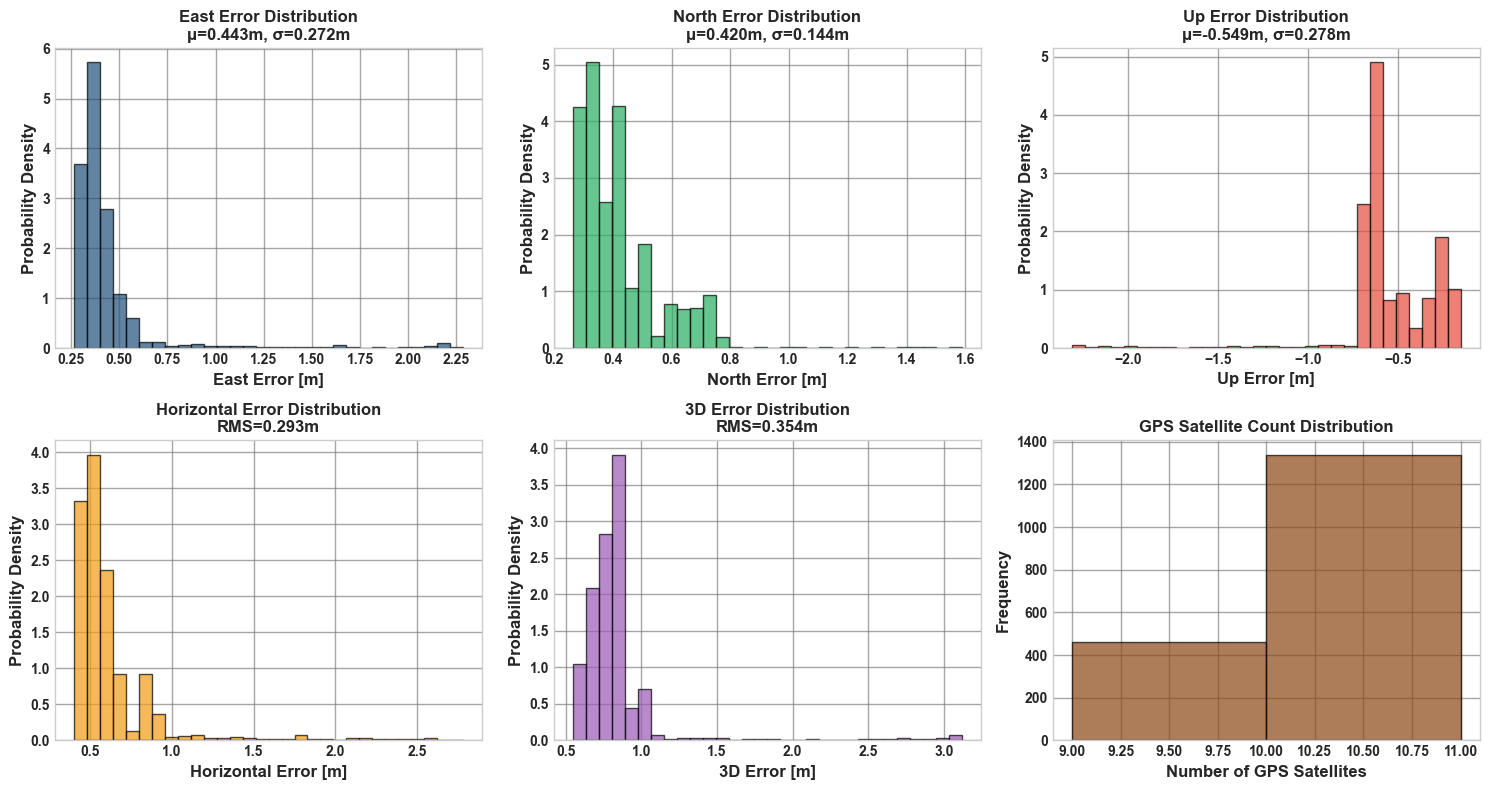


ERROR DISTRIBUTION STATISTICS
Valid Solutions: 1800 epochs

Component-wise Statistics:
  East  - Mean:  0.443m, Std:  0.272m
  North - Mean:  0.420m, Std:  0.144m
  Up    - Mean: -0.549m, Std:  0.278m

Combined Statistics:
  Horizontal RMS:  0.293m
  3D RMS:          0.354m
  Average GPS Satellites:  9.7


In [28]:
# Create error distribution plots with enhanced styling
plt.style.use('seaborn-v0_8-whitegrid')  # White background with visible grid
fig, axes = plt.subplots(2, 3, figsize=[15, 8])
fig.patch.set_facecolor('white')

# Only use valid solutions
valid_idx = smode > 0
valid_enu = enu[valid_idx, :]

# East error histogram
ax = axes[0, 0]
ax.hist(valid_enu[:, 0], bins=30, density=True, alpha=0.7, color='#1f4e79', edgecolor='black', linewidth=1)
ax.set_xlabel('East Error [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'East Error Distribution\nμ={np.mean(valid_enu[:, 0]):.3f}m, σ={np.std(valid_enu[:, 0]):.3f}m', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# North error histogram  
ax = axes[0, 1]
ax.hist(valid_enu[:, 1], bins=30, density=True, alpha=0.7, color='#27AE60', edgecolor='black', linewidth=1)
ax.set_xlabel('North Error [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'North Error Distribution\nμ={np.mean(valid_enu[:, 1]):.3f}m, σ={np.std(valid_enu[:, 1]):.3f}m', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Up error histogram
ax = axes[0, 2]
ax.hist(valid_enu[:, 2], bins=30, density=True, alpha=0.7, color='#E74C3C', edgecolor='black', linewidth=1)
ax.set_xlabel('Up Error [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'Up Error Distribution\nμ={np.mean(valid_enu[:, 2]):.3f}m, σ={np.std(valid_enu[:, 2]):.3f}m', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Horizontal error histogram
horizontal_error = np.sqrt(valid_enu[:, 0]**2 + valid_enu[:, 1]**2)
ax = axes[1, 0]
ax.hist(horizontal_error, bins=30, density=True, alpha=0.7, color='#F39C12', edgecolor='black', linewidth=1)
ax.set_xlabel('Horizontal Error [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'Horizontal Error Distribution\nRMS={np.std(horizontal_error):.3f}m', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# 3D error histogram  
error_3d = np.sqrt(valid_enu[:, 0]**2 + valid_enu[:, 1]**2 + valid_enu[:, 2]**2)
ax = axes[1, 1]
ax.hist(error_3d, bins=30, density=True, alpha=0.7, color='#9B59B6', edgecolor='black', linewidth=1)
ax.set_xlabel('3D Error [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'3D Error Distribution\nRMS={np.std(error_3d):.3f}m', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Satellite count histogram
ax = axes[1, 2]
ax.hist(nsat_gps[nsat_gps > 0], bins=range(int(min(nsat_gps)), int(max(nsat_gps))+2), 
        alpha=0.7, color='#8B4513', edgecolor='black', linewidth=1)
ax.set_xlabel('Number of GPS Satellites', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('GPS Satellite Count Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.7, color='gray', linewidth=1)
ax.set_facecolor('white')
# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Print distribution statistics with bold formatting
print("\n" + "="*70)
print("ERROR DISTRIBUTION STATISTICS")
print("="*70)
print(f"Valid Solutions: {len(valid_enu)} epochs")
print(f"\nComponent-wise Statistics:")
print(f"  East  - Mean: {np.mean(valid_enu[:, 0]):6.3f}m, Std: {np.std(valid_enu[:, 0]):6.3f}m")
print(f"  North - Mean: {np.mean(valid_enu[:, 1]):6.3f}m, Std: {np.std(valid_enu[:, 1]):6.3f}m")
print(f"  Up    - Mean: {np.mean(valid_enu[:, 2]):6.3f}m, Std: {np.std(valid_enu[:, 2]):6.3f}m")
print(f"\nCombined Statistics:")
print(f"  Horizontal RMS: {np.std(horizontal_error):6.3f}m")
print(f"  3D RMS:         {np.std(error_3d):6.3f}m")
print(f"  Average GPS Satellites: {np.mean(nsat_gps[nsat_gps > 0]):4.1f}")
print("="*70)

## CDF of Positioning Errors

This section plots the Cumulative Distribution Functions (CDFs) of horizontal, vertical, and 3D errors. CDFs help quantify the probability of staying within a given error bound and allow reading common percentiles (50%, 68%, 95%, 99%).


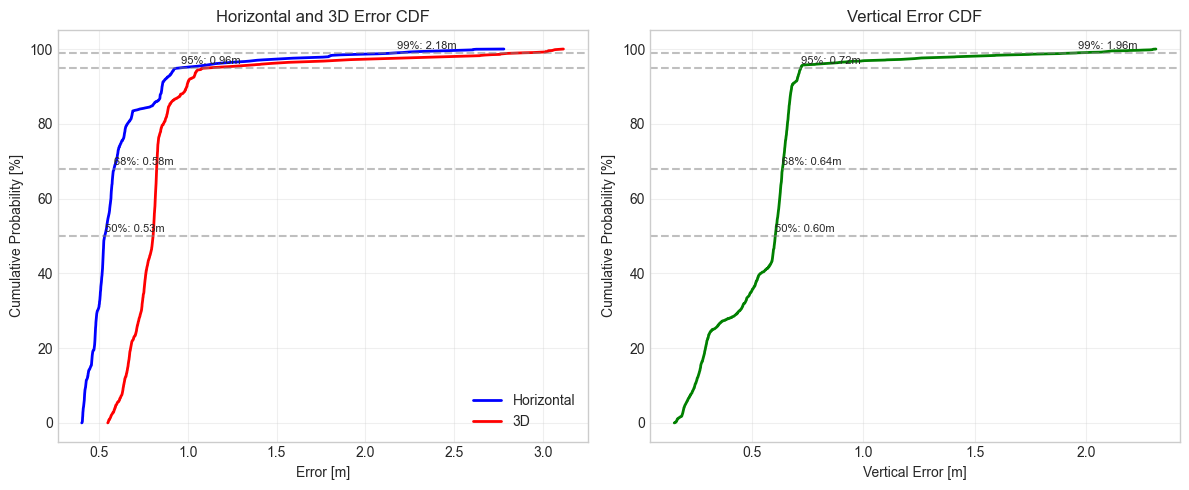

In [29]:
# Plot CDF for error analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])

# Calculate CDFs
valid_idx = smode > 0
horizontal_error = np.sqrt(enu[valid_idx, 0]**2 + enu[valid_idx, 1]**2)
vertical_error = np.abs(enu[valid_idx, 2])
error_3d = np.sqrt(enu[valid_idx, 0]**2 + enu[valid_idx, 1]**2 + enu[valid_idx, 2]**2)

# Sort errors for CDF
h_sorted = np.sort(horizontal_error)
v_sorted = np.sort(vertical_error)
d3_sorted = np.sort(error_3d)
p = 100 * np.arange(len(h_sorted)) / (len(h_sorted) - 1)

# Horizontal and 3D CDF
ax1.plot(h_sorted, p, 'b-', linewidth=2, label='Horizontal')
ax1.plot(d3_sorted, p, 'r-', linewidth=2, label='3D')
ax1.set_xlabel('Error [m]')
ax1.set_ylabel('Cumulative Probability [%]')
ax1.set_title('Horizontal and 3D Error CDF')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add percentile lines
percentiles = [50, 68, 95, 99]
for perc in percentiles:
    ax1.axhline(y=perc, color='gray', linestyle='--', alpha=0.5)
    h_val = np.percentile(horizontal_error, perc)
    ax1.text(h_val, perc+1, f'{perc}%: {h_val:.2f}m', fontsize=8)

# Vertical CDF
ax2.plot(v_sorted, p, 'g-', linewidth=2)
ax2.set_xlabel('Vertical Error [m]')
ax2.set_ylabel('Cumulative Probability [%]')
ax2.set_title('Vertical Error CDF')
ax2.grid(True, alpha=0.3)

# Add percentile lines
for perc in percentiles:
    ax2.axhline(y=perc, color='gray', linestyle='--', alpha=0.5)
    v_val = np.percentile(vertical_error, perc)
    ax2.text(v_val, perc+1, f'{perc}%: {v_val:.2f}m', fontsize=8)

plt.tight_layout()
plt.show()